In [169]:
import torch
import numpy as np
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt


from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [170]:
def plotting_losses(cnn, cnn_batch_norm):
    plt.plot(cnn.detach(), 'r', label="CNN")
    plt.plot(cnn_batch_norm.detach(), 'k', label="CNN with Batch Norm")
    plt.legend()
    plt.show()

def acc_plot(cnn, cnn_batch_norm):
    plt.plot(cnn, 'r', label="CNN")
    plt.plot(cnn_batch_norm, 'k', label="CNN with Batch Norm")
    plt.legend()
    plt.show()

def plot_images(images):
    for image in images:
        plt.figure()
        plt.imshow(image)


The transforms chosen by us are `RandomHorizontalFlip`, `RandomRotation`, `Random Affine`, `ColorJitter`and finally `Normalize`.
These transforms were chosen because they do not drastically change the features of the image but make the model more robust since the photos are now randomly rotated and flipped thus increasing the datatset and the model gets to learn the features better.


In [171]:
class Dataset:
    def __init__(self, images: torch.Tensor, labels: torch.Tensor, mode: str):
        self.mode = mode
        self.images = images
        self.labels = labels
        self.train_transform = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.RandomHorizontalFlip(0.3), # FLips the image w.r.t horizontal axis
                                                   transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                                   transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                                   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                                   transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                                   transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                        std=[0.5, 0.5, 0.5])]) #Normalize all the images



        self.test_transform = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                 ])
    def __len__(self):
        a = len(self.labels)
        return a

    def __getitem__(self, index):
#         image = self.images[index]
        image = self.images[index]
        label = self.labels[index]
        if self.mode == "train":
            image = self.train_transform(image)
        elif self.mode == "test":
            image = self.test_transform(image)
        return image, label

In [172]:
dataset_x = datasets.CIFAR10(root = "../cifar/", train = True, download = False)
dataset_y = datasets.CIFAR10(root = "../cifar/", train = False, download = False)
train_dataset = Dataset(dataset_x.data, dataset_x.targets, "train")
test_dataset = Dataset(dataset_y.data, dataset_y.targets, "test")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = True, pin_memory=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


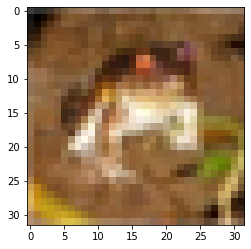

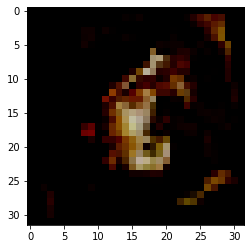

In [173]:
image_before = dataset_x[0][0]
image_after = train_dataset[0][0].transpose(0,2)
images = [image_before, image_after]
plot_images(images)

In [174]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)

        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)

        x = torch.randn(32,32,3).view(-1,3,32,32)

        self._to_linear = None
        self.convs(x)

        self.fc = nn.Linear(self._to_linear, 10)

    def convs(self,x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x , (2,2))

        #Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x , (2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return x

In [175]:
def train(model, optimizer, dataloader):
    for x,y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        prediction = model.forward(x)
        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y)
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc

In [176]:
def training(model_factory, dataloader, optimizer_factory, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory

    for epoch in tqdm(range(epochs)):
        losses[epoch] = train(model, optimizer, dataloader)
        accuracies[epoch] = accuracy(model, test_loader)
        sleep(0.1)
        print(f"Loss of Epoch {epoch} is {losses[epoch]}")
        print(f"Accuracy of Epoch {epoch} is {accuracies[epoch]}")
    return losses, accuracies


In [177]:
class Network_Norm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)

        x = torch.randn(32,32,3).view(-1,3,32,32)

        self._to_linear = None
        self.convs(x)

        self.fc = nn.Linear(self._to_linear, 10)

    def convs(self,x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(self.conv2(x)))
        x = F.max_pool2d(x , (2,2))

        #Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.max_pool2d(x , (2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return x

    def convs_test(self,x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x , (2,2))

        #Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x , (2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward_test(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return x

In [178]:
def train_fc(model, optimizer, dataloader, batch:bool):
    for x, y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        if batch == True:
            prediction = model.forward(x)
        else:
            prediction = model.forward_test(x)
        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y.to(torch.long))
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy_fc(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward_test(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc

In [179]:
def batch_norm(model_factory, optimizer_factory, dataloader, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train_fc(model, optimizer, dataloader, True)
        accuracies[epoch] = accuracy_fc(model, test_loader)
        print(f"The loss of {epoch} is {losses[epoch]}")
        print(f"The accuracy of {epoch} is {accuracies[epoch]}")
        sleep(0.1)
    return losses, accuracies

In [180]:
model1 = Network_Norm()
optimizer1  = optim.Adam(model1.parameters(), lr= 0.0005, betas= (0.9, 0.95))
batch_losses, batch_accuracies = batch_norm(model1, optimizer1, train_loader, 25)

100%|██████████| 25/25 [18:33<00:00, 44.55s/it]


The loss of 0 is 1.1879993677139282
The accuracy of 0 is 0.5891000032424927
The loss of 1 is 1.1618212461471558
The accuracy of 1 is 0.6593999862670898
The loss of 2 is 1.1951428651809692
The accuracy of 2 is 0.699999988079071
The loss of 3 is 0.7369775772094727
The accuracy of 3 is 0.7213999629020691
The loss of 4 is 1.0667788982391357
The accuracy of 4 is 0.7357999682426453
The loss of 5 is 0.8239547610282898
The accuracy of 5 is 0.7447999715805054
The loss of 6 is 0.7277995347976685
The accuracy of 6 is 0.7509999871253967
The loss of 7 is 1.0218677520751953
The accuracy of 7 is 0.7577999830245972
The loss of 8 is 0.7566356658935547
The accuracy of 8 is 0.7710999846458435
The loss of 9 is 0.7046812772750854
The accuracy of 9 is 0.7698999643325806
The loss of 10 is 0.6197318434715271
The accuracy of 10 is 0.7683999538421631
The loss of 11 is 0.7447744011878967
The accuracy of 11 is 0.7787999510765076
The loss of 12 is 0.7398411631584167
The accuracy of 12 is 0.7834999561309814
The los

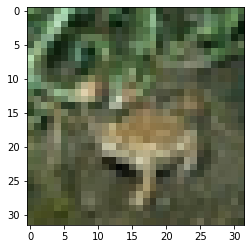

In [255]:
#Task C-1

dataset_y2 = datasets.CIFAR10(root = "../cifar/", train = False, download = False,transform=transforms.ToTensor())

image_index=random.randint(0,len(dataset_y2))
random_image=dataset_y[image_index][0]
plot_images([random_image])

In [256]:
#Task C-2

def hook_function(model, input, output):
    feature_maps[model]=output

def get_layers(net):
    for name, layer in net._modules.items():
        if isinstance(layer, nn.Sequential):
            get_layers(layer)
        else:
            layer.register_forward_hook(hook_function)

feature_maps={}
get_layers(model1)
image_data=dataset_y2[image_index][0].unsqueeze_(0)
image_data=image_data.to('cuda:0')
prediction = model1(image_data)

print(feature_maps)


{Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1)): tensor([[[[ 1.1176e-01,  7.0454e-02,  3.3013e-03,  ...,  1.1585e-01,
            9.2761e-02,  1.6904e-01],
          [ 1.1466e-01,  7.7015e-02,  4.6184e-02,  ...,  1.9135e-01,
            1.5999e-01,  2.8286e-01],
          [ 6.6823e-02,  1.8657e-02,  1.4041e-01,  ...,  2.1153e-01,
            1.9827e-01,  2.2522e-01],
          ...,
          [ 1.3468e-01,  1.5978e-01,  1.6859e-01,  ...,  1.2335e-01,
            1.2318e-01,  1.5762e-01],
          [ 1.4615e-01,  1.5639e-01,  1.5146e-01,  ...,  1.2392e-01,
            1.2454e-01,  1.2665e-01],
          [ 1.4203e-01,  1.4705e-01,  1.3871e-01,  ...,  9.1934e-02,
            1.6253e-01,  1.7076e-01]],

         [[-4.2830e-02,  1.4185e-01,  4.0907e-01,  ...,  7.2556e-02,
            9.9743e-02, -1.9621e-01],
          [ 9.8495e-02,  2.6926e-01,  3.3010e-01,  ..., -3.2396e-03,
           -1.8183e-02, -3.1712e-01],
          [ 1.1465e-01,  2.8086e-01,  5.9726e-02,  ..., -3.2557e-02,
       